In [1]:
from frechet_fda.data_generation_helpers import (
    gen_params_scenario_one,
    make_truncnorm_pdf,
)
from frechet_fda.distribution_tools import (
    get_optimal_range,
    make_distribution_objects,
    qdf_to_pdf,
    pdf_to_qdf
)
from frechet_fda.fda_funcs import (
    compute_centered_data,
    compute_cov_function,
    compute_fpc_scores,
    compute_principal_components,
    mode_of_variation
)

In [2]:
# Set parameters
n = 200
grid_size = 10000
trunc = 3
mus, sigmas = gen_params_scenario_one(n)
# Sort sigmas, because when summing Distribution instances something goes wrong otherwise
sigmas.sort()

In [3]:
# Generate pdfs within truncation points
pdfs = make_truncnorm_pdf(-trunc, trunc, mus, sigmas, grid_size=grid_size)
# Make Distribution class objects
my_pdfs = make_distribution_objects(pdfs)
my_cdfs = [pdf.integrate() for pdf in my_pdfs]
my_qfs = [cdf.invert() for cdf in my_cdfs]
my_qdfs = [qf.differentiate() for qf in my_qfs]
# For numerical correction: shorten the range for smaller sigmas to get rid of
# numerical artifacts when computing integrals, derivatives and means later
new_ranges = get_optimal_range(my_pdfs)
# Generate pdfs again, this time within individual ranges
pdfs2 = [
    make_truncnorm_pdf(
        new_ranges[i][0], new_ranges[i][1], mus[i], sigmas[i], grid_size=grid_size,
    )[0]
    for i in range(n)
]

C:\Coding\thesis_frechet_fda\src\frechet_fda\data_generation_helpers.py:65: UserWarning: Not all provided densities integrate to 1 with tolerance 1e-05!
 Max case of deviation is: 0.00045380448286858055
 In position: 199
 Performing normalization...
  warnings.warn(
C:\Coding\thesis_frechet_fda\src\frechet_fda\numerics_helpers.py:36: RuntimeWarning: divide by zero encountered in divide
  d_y[:-1] = np.diff(y_vals) / np.diff(d_x)
C:\Coding\thesis_frechet_fda\src\frechet_fda\data_generation_helpers.py:65: UserWarning: Not all provided densities integrate to 1 with tolerance 1e-05!
 Max case of deviation is: 1.0512038445709138e-05
 In position: 0
 Performing normalization...
  warnings.warn(
C:\Coding\thesis_frechet_fda\src\frechet_fda\data_generation_helpers.py:65: UserWarning: Not all provided densities integrate to 1 with tolerance 1e-05!
 Max case of deviation is: 1.1517970267549416e-05
 In position: 0
 Performing normalization...
  warnings.warn(
C:\Coding\thesis_frechet_fda\src\frec

In [4]:
# Generate all the distribution objects
new_pdfs = make_distribution_objects(pdfs2)
new_cdfs = [pdf.integrate() for pdf in new_pdfs]
new_qfs = [cdf.invert() for cdf in new_cdfs]
new_qdfs = [qf.differentiate() for qf in new_qfs]

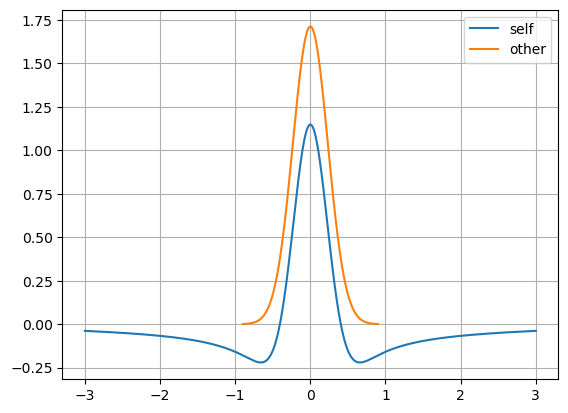

In [5]:
# Compute centered data, just to see whether it works
# One can clearly see how inappropriate it is to apply fda methods on densities
mean_pdf, centered_pdfs = compute_centered_data(new_pdfs)
centered_pdfs[sigmas.argmin()].compare(new_pdfs[sigmas.argmin()])

In [6]:
covariance_function = compute_cov_function(centered_pdfs)

In [7]:
eigenvalues, eigenfunctions = compute_principal_components(
    centered_pdfs[0].x, covariance_function,
)

## Transformation FPCA

In [8]:
import numpy as np

In [9]:
def log_qd_transform(densities_sample):
    """Perfrom log quantile density transformation on a density sample."""
    qdfs = [pdf_to_qdf(density) for density in densities_sample]
    return [qdf.log() for qdf in qdfs]

In [10]:
def inverse_log_qd_transform(transformed_funcs):
    natural_qfs = [func.exp().integrate().vcenter() for func in transformed_funcs]
    cdfs = [qf.invert() for qf in natural_qfs]
    exponents = [-func.compose(cdf) for func, cdf in zip(transformed_funcs, cdfs)]
    return [exponent.exp() for exponent in exponents]

In [11]:
def inverse_log_qd_transform(transformed_funcs):
    """Invert the log quantile density transform to get back into density space."""
    # First compute quantile function via natural inverse
    natural_qfs = [func.exp().integrate().vcenter() for func in transformed_funcs]
    # Compute correction factors to normalize quantiles
    thetas = [qf.y[-1] for qf in natural_qfs]
    corrected_qfs = [
        qf / theta for qf, theta in zip(natural_qfs, thetas)
    ]
    cdfs = [qf.invert() for qf in corrected_qfs]
    exponents = [func.compose(cdf) for func, cdf in zip(transformed_funcs, cdfs)]
    inverses = [theta / exponent.exp() for theta, exponent in zip(thetas, exponents)]

    return inverses

In [12]:
def gen_qdtransformation_pcs(log_qdfs):
    """Perform FPCA on transformed densities."""
    mean, centered_data = compute_centered_data(log_qdfs)
    covariance_function = compute_cov_function(centered_data)
    eigenvalues, eigenfunctions = compute_principal_components(
        centered_data[0].x, covariance_function,
    )
    fpc_scores = compute_fpc_scores(centered_data[0].x, centered_data, eigenfunctions)
    return mean, eigenvalues, eigenfunctions, fpc_scores


In [13]:
def mode_of_variation(mean, eigval, eigfunc, alpha):
    """Compute kth mode of variation."""
    return mean + alpha * np.sqrt(eigval) * eigfunc

In [22]:
def karhunen_loeve(mean_function, eigenfunctions, fpc_scores, K : int = 3):
    truncated_reps = []
    for i in range(len(fpc_scores)):
        aggr = mean_function
        for k in range(K):
            aggr += eigenfunctions[k] * fpc_scores[i][k]
        truncated_reps.append(aggr)
    return truncated_reps


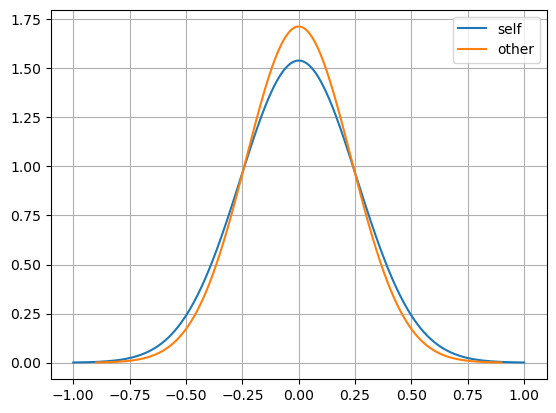

In [15]:
log_qdfs = log_qd_transform(new_pdfs)
inverse_log_qdfs = inverse_log_qd_transform(log_qdfs)
inverse_log_qdfs[0].compare(new_pdfs[0])

In [17]:
(
    mean_log_qdfs,
    eigenvalues_log_qdfs,
    eigenfunctions_log_qdfs,
    fpc_scores_log_qdfs,
) = gen_qdtransformation_pcs(log_qdfs)

In [33]:
truncated_representations_transforms = karhunen_loeve(mean_log_qdfs, eigenfunctions_log_qdfs, fpc_scores_log_qdfs)

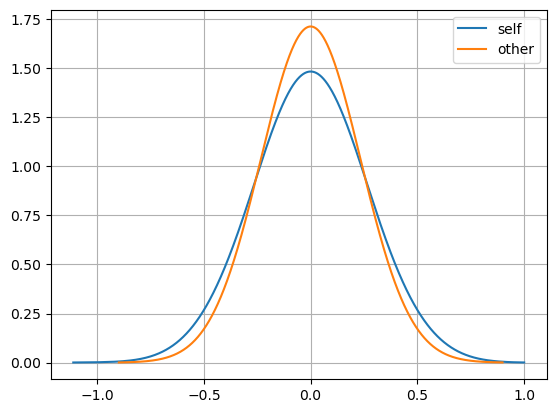

In [39]:
inverse_log_qd_transform(truncated_representations_transforms)[0].compare(new_pdfs[0])

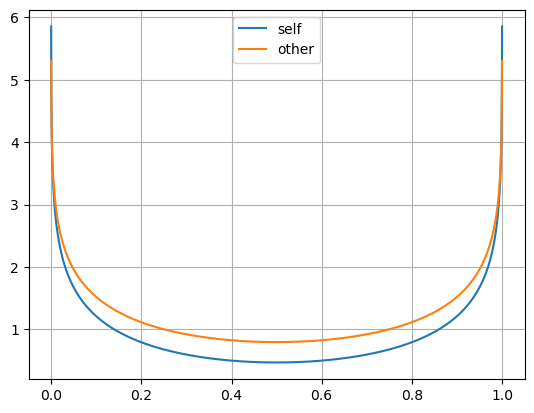

In [ ]:
variation_modes_transforms = [
    mode_of_variation(
        mean_log_qdfs,
        eigval,
        eigfunc,
        alpha=5e-3
    )
    for eigval, eigfunc in zip(eigenvalues_log_qdfs, eigenfunctions_log_qdfs)
]
variation_modes_transforms[0].compare(variation_modes_transforms[1])

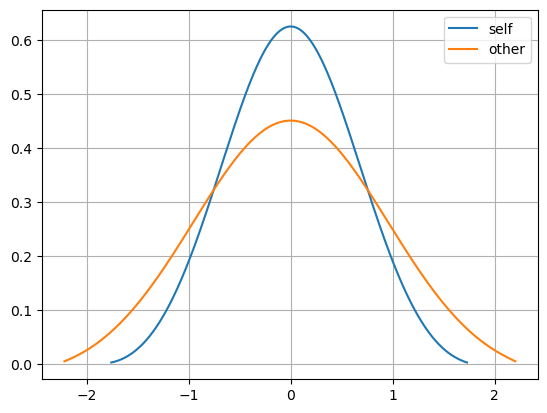

In [ ]:
variation_modes = inverse_log_qd_transform(variation_modes_transforms)
variation_modes[0].compare(variation_modes[1])


# Correction factor for transformations

Dont see the use of it in my implementation, on hold for now

In [ ]:
def inverse_log_qd_transform_corrected(transformed_funcs):
    """Invert the log quantile density transform to get back into density space. Use
    correction factor."""
    # First compute quantile function via natural inverse
    natural_qfs = [func.exp().integrate().vcenter() for func in transformed_funcs]
    # Compute correction factors to normalize quantiles
    thetas = [qf.y[-1] for qf in natural_qfs]
    corrected_qfs = [
        qf / theta for qf, theta in zip(natural_qfs, thetas)
    ]
    cdfs = [qf.invert() for qf in corrected_qfs]
    exponents = [func.compose(cdf) for func, cdf in zip(transformed_funcs, cdfs)]
    inverses = [theta / exponent.exp() for theta, exponent in zip(thetas, exponents)]

    return inverses